# SEIR model with data for Santa Cruz County
 * to modify with you own data or parameters edit the cells underneath the "**user input:**" header below

### some preparation

In [1]:
import os
import datetime
import numpy as np
import pystan
import logging
from dateutil.parser import parse

data = {}

# user input:

The model requires two data files:
 1. `datafile_confirmedcases` is a file containing the (cumulative) number of confirmed cases and the number of deaths due to COVID-19. 
  * It can be provided as an Excel file with columns named "date", "confirmed", "deaths", see [example file](data/santa_cruz_cases.xlsx)
  * It can be provided as a comma or space-separated text file in which the first 3 columns contain "date", "confirmed cases" and "deaths", see [example file](data/santa_cruz_cases.txt)
 2. `datafile_hospitalizations` is a file containing the (current) number of hospitalized (ICU and non-ICU) patients and the number of ICU patients due to COVID-19. 
  * It can be provided as an Excel file with columns named "date", "hospitalized", "ICU", see [example file](data/santa_cruz_hospitalized.xlsx)
  * It can be provided as a comma or space-separated text file in which the first 3 columns contain "date", "confirmed cases" and "deaths", see [example file](data/santa_cruz_hospitalized.txt)
  
**Note:** If you are unsure if the data was read in correctly, check the first plot below, it should contain all 4 types of data.

In [2]:
# the name of the two data files
datafile_confirmedcases = 'data/santa_cruz_cases.txt'
datafile_hospitalizations = 'data/santa_cruz_hospitalized.txt'

# the start date at which to start the simulation
startdate_str = '2020-02-16'

# the number of days to run the model for
data['nt'] = 250

The model permits the specification of multiple age groups of the susceptiple population and the fraction of infected who require hospitalization (ICU + non-ICU; `frac_hosp`), ICU (`frac_icu`), the mortality rate of infected (`frac_mort`) and the fraction of asymptomatic cases (`frac_asym`) for each age group. The remaining cases are assumed to be "mild" cases who recover at home. If no age structure information is available, or if the goal is to estimate the abovementioned fractions (see below), set `nage` to 1.

The fraction of infectious cases are modeled using a Dirichlet distribution. The parameter `alpha_multiplier` adjusts the variance of the prior distribution for each fraction thereby allowing fractions to be estimated by the model (for lower values of `alpha_multiplier`, e.g. 100) or to remain fixed (higher values of `alpha_multiplier`, e.g. 1000). It is not recommended to estimate fractions if `nage` (above) is greater than 1, that is if multiple age groups are used.

In [3]:
# the number of age groups
data['nage'] = 1 

# Note: The inputs below must be lists or arrays, even if just one age group is specified 
# (the enclosing "[]" are not optional).

# the population for each age group
data['npop'] = [273765] 
# the fraction of hospitalized cases (ICU + non-ICU)
data['frac_hosp'] = [0.07]
# the fraction of ICU cases
data['frac_icu'] = [0.02] 
# the death rate of infected
data['frac_mort'] = [0.005]
# the fraction of asymptomatic cases
data['frac_asym'] = [0.178]

# a parameter modifying the prior uncertainty in the fractions above (set to 1000.0 for `nage` > 1)
data['alpha_multiplier'] = 100.0

The following parameters specify the prior distribution for the model parameters. Most of the parameters are modeled by a normal distribution for which a mean ($\mu$, `mu_*`) and standard deviation ($\sigma$, `sigma_*`) need to be specified.

Currently, the initial conditions at the start date of the simulation assume zero infectious cases and a small number of exposed individuals. The prior distribution for the number of initially exposed individuals is modeled using an exponential distribution with a parameter `lambda_ini_exposed`. 1/`lambda_ini_exposed` is the mean of the distribution.

In [4]:
# mean duration in "exposed" stage
data['mu_duration_lat'] = 5.0
# standard deviation (sd) of duration in "exposed" stage
data['sigma_duration_lat'] = 2.0
# mean duration in "infectious" stage for asymptomatic cases
data['mu_duration_rec_asym'] = 7.0
# sd of duration in "infectious" stage for asymptomatic cases
data['sigma_duration_rec_asym'] = 5.0
# mean duration in "infectious" stage for mild cases
data['mu_duration_rec_mild'] = 7.0
# sd of duration in "infectious" stage for mild cases
data['sigma_duration_rec_mild'] = 5.0
# mean duration in "infectious" stage for hospitalized cases
data['mu_duration_pre_hosp'] = 5.0
# sd of duration in "infectious" stage for hospitalized cases
data['sigma_duration_pre_hosp'] = 1.0
# mean duration in hospital for non-ICU cases
data['mu_duration_hosp_mod'] = 7.0
# sd of duration in hospital for non-ICU cases
data['sigma_duration_hosp_mod'] = 1.0
# mean duration in hospital for ICU cases
data['mu_duration_hosp_icu'] = 16.0
# sd of duration in hospital for ICU cases
data['sigma_duration_hosp_icu'] = 4.0

# lambda parameter for initial conditions of "exposed"
data['lambda_ini_exposed'] = 0.3

The following 4 parameters are related to the fitting of observations in the model. Each of the 4 observation types (confirmed cases (`Iobs`), non-ICU hospitalizations (`Hmod`), ICU hospitalizations (`Hicu`), and deaths (`Rmort`)) has its own observation uncertainty, and the misfit between model and observations varies between the types. The standard deviation of the model-observation misfit is assumed to have an exponential distribution with a parameter $\lambda$ (`lambda`). The 4 parameters below specify the value of $\lambda$ for each observation type. Because $1/\lambda$ is the mean of an exponential distribution, a larger value of a specific $\lambda$ presumes a tighter fit to the corresponding observation type and lowering the value loosens the fit.

The current default presumes a tighter fit to the mortality data (larger value of `lambda_Rmort`) and a looser fit to confirmed case count (lower value of `lambda_Iobs`) with the hospitalization data in between.

In [5]:
# lambda parameter for Iobs observation misfit
data['lambda_Iobs'] = 0.1
# lambda parameter for Hmod observation misfit
data['lambda_Hmod'] = 1.0
# lambda parameter for Hicu observation misfit
data['lambda_Hicu'] = 1.0
# lambda parameter for Rmort observation misfit
data['lambda_Rmort'] = 10.0

The next set of parameters are related to the fraction of infectious who have been tested, which links newly infectious in the model to the confirmed cases in the data. One option is to assume no time-dependence in the prior for the estimated fraction of infectious who have been tested (set `fractest_timedependent = False`) or to assume time-dependence in the prior (set `fractest_timedependent = True`), e.g. to account for an increase in testing.

With time-dependence, the time-evolution of the fraction tested is prescribed using a spline curve of degree `p_fractest`. Using `p_fractest = 1` (like below), uses linear interpolation in time to describe the time-evolution of the fraction tested prior: At a set of time points, normal distributions are prescribed (using mean and standard deviation of the fraction of newly infectious who get tested) which are interpolated between the knots. Use `create_spline_plot = True` to create a plot of the interpolation result before running the Stan model.

Without time-dependence, the prior distribution of the fraction of tested infectious is simply prescribed by a single normal distribution.

In [6]:
fractest_timedependent = True

if fractest_timedependent:
    # with time-dependence: 
    
    # the order of the splines used (set to 1 for linear interpolation)
    data['p_fractest'] = 1
    
    # the time-points at which to prescribe a new distribution
    # Note: The first entry must be the start day, the last must be the last day of the simulation 
    # (if this is not the case they are automatically corrected).
    dates_fractest_str = [startdate_str,'2020-03-09','2020-04-27','2020-05-18','2020-09-02']
    
    # mean fraction of tested infectious (one entry for every entry in dates_fractest_str above)
    data['mu_fractest'] = [0.1,0.15,0.2,0.5,0.7]
    # sd fraction of tested infectious(one entry for every entry in dates_fractest_str above)
    data['sigma_fractest'] = [0.1,0.1,0.2,0.2,0.2]
    
    # If create_spline_plot is set to true, a plot of the interpolation result 
    # for the mean of the prior distribution) is created below the data plot.
    create_spline_plot = False
else:
    # without time-dependence:
    
    # mean fraction of tested infectious
    data['mu_frac_tested'] = 0.25
    # sd fraction of tested infectious
    data['sigma_frac_tested'] = 0.1

The model also requires the specification of the distribution for the initial value of $\beta$ using a normal distribution with mean `mu_beta1` and standard deviation `sigma_beta1`.

The remaining values for $\beta$ are estimated based on the input data every `dknot` days (using an AR(1) process and Spline interpolation). The spline interpolation offers two transition modes to extrapolate the values of $\beta$ beyond the current date after which no data is available. Setting `splinemode` to 1 will allow the spline to be estimated freely until the current date. The more conservative option `splinemode` = 2 assumes a constant value for $\beta$ in the last `dknot` days before the current date.    

In [7]:
# mean initial beta estimate
data['mu_beta1'] = 0.2
# sd initial beta estimate
data['sigma_beta1'] = 0.02

# distance in time between the knots used to construct the splines 
data['dknot'] = 5

# itoday_1based is the (1-based) time index corresponding to the current date
itoday_1based = (datetime.datetime.now()-parse(startdate_str)).days + 1
# specify the date up to when beta is estimated
data['itoday'] = itoday_1based

# spline mode (must be 1 or 2)
# splinemode = 1: estimate beta up to today
# splinemode = 2: estimate beta up to dknot days before today, then assume constant value up to today
data['splinemode'] = 1

Interventions permit the modification of $\beta$ past the current date. `ninter` is the number of interventions (allowed to be zero for no interventions). Each intervention has a start time (`t_inter`) and a length (in days) over which $\beta$ is adjusted. Each intervention leads to a multiplication of the value of $\beta$ before the intervention with a random number drawn from a normal distribution with mean `mu_beta_inter` and standard deviation `sigma_beta_inter`. That is, an intervention with `mu_beta_inter` set to 1.2 will lead to an average increase in $\beta$ by 20%, 0.8 to an average decrease by 20%; a value of 1.0 will lead to no mean increase but a higher spread (less certainty) in the value of $\beta$ after the intervention.

In [8]:
# number of interventions
data['ninter'] = 1

# Note: The inputs below must be lists or arrays, even if one intervention is specified 
# (the enclosing "[]" are not optional for single interventions).

# start time of each interventions
data['t_inter'] = [itoday_1based+5]
# length of each intervention
data['len_inter'] = [10]
# mean change in beta through intervention 
data['mu_beta_inter'] = [1.0]
# sd change in beta through intervention
data['sigma_beta_inter'] = [0.2]

**Advanced options for performing multiple simulations (leave unchanged if not needed)**. The parameter `stan_file` specifies Stan code file used in the simulation. `datachanges` allows running multiple simulations with different parameters (optional).

In [9]:
if fractest_timedependent:
    stan_file = {'SEIR':'stan_code/seir_v9.stan'}    
else:
    stan_file = {'SEIR':'stan_code/seir_v8.stan'}

# define alternative parametrizations here (optional, comment out if not needed)
#datachanges = {'ref':None}

# a brief description of each parametrization (optional, comment out if not needed)
#desc = {'ref':'reference simulation'}

# if running different Stan code versions provide a key to a stan_file entry for each datachanges entry
# (optional, comment out if not needed)
#datachange_stan_key = {'ref':'SEIR'}

## end of user input

In [10]:
def read_data(filename, filetype, **kwargs):
    if os.path.splitext(filename)[1] in ('.xls','.xlsx'):
        if 'colnames_data' not in kwargs:
            if filetype == 'confirmedcases':
                kwargs['colnames_data'] = ('confirmed','deaths')
            elif filetype == 'hospitalizations':
                kwargs['colnames_data'] = ('hospitalized','ICU')
        return read_data_excel(filename, **kwargs)
    elif os.path.splitext(filename)[1] == '.csv':
        return read_data_txt(filename, separator=',', **kwargs)
    else:
        return read_data_txt(filename, **kwargs)
    
def read_data_txt(filename, separator=None, icol_date=0, icol_data=(1,2)):
    res = tuple([] for i in range(len(icol_data)+1))
    with open(filename) as f:
        for line in f:
            if line.strip().startswith('#'):
                continue
            line_parts = line.strip().split(separator)
            res[0].append(parse(line_parts[icol_date]))
            for i,icol in enumerate(icol_data):
                res[i+1].append(int(line_parts[icol]))
    return tuple(np.array(r) for r in res)

def read_data_excel(filename, colname_date='date', colnames_data=None):
    import pandas
    df = pandas.read_excel(filename)
    res = [np.array([pandas.to_datetime(d) for d in df[colname_date].values])]
    for colname in colnames_data:
        res.append(df[colname].values)
    return tuple(np.array(r) for r in res)

In [11]:
# note that the reference date is one day ahead of the start date 
# (day 1 when Stan starts simulation is 2020-02-17)
refdate = parse(startdate_str) - datetime.timedelta(days=1)
itoday = itoday_1based-1

tobs_date, obs_I, obs_Rmort = read_data(filename=datafile_confirmedcases, filetype='confirmedcases')
tobs = np.array([(d-refdate).days for d in tobs_date])

thobs_date, obs_H, obs_Hicu = read_data(filename=datafile_hospitalizations, filetype='hospitalizations')
thobs = np.array([(d-refdate).days for d in thobs_date])

# update Stan input with data read from files

data.update({'nobs':len(tobs), 'tobs':tobs, 'obs_I':obs_I, 'obs_Rmort':obs_Rmort,
             'nhobs':len(thobs), 'thobs':thobs, 'obs_Hmod':obs_H-obs_Hicu, 'obs_Hicu':obs_Hicu})

# add additional parameters

if fractest_timedependent:
    data['knots_fractest'] = np.array([(parse(d)-refdate).days for d in dates_fractest_str])
    data['knots_fractest'][0] = 1
    data['knots_fractest'][-1] = data['nt']
    data['nknots_fractest'] = len(data['knots_fractest'])

### prepare plotting and plot the data

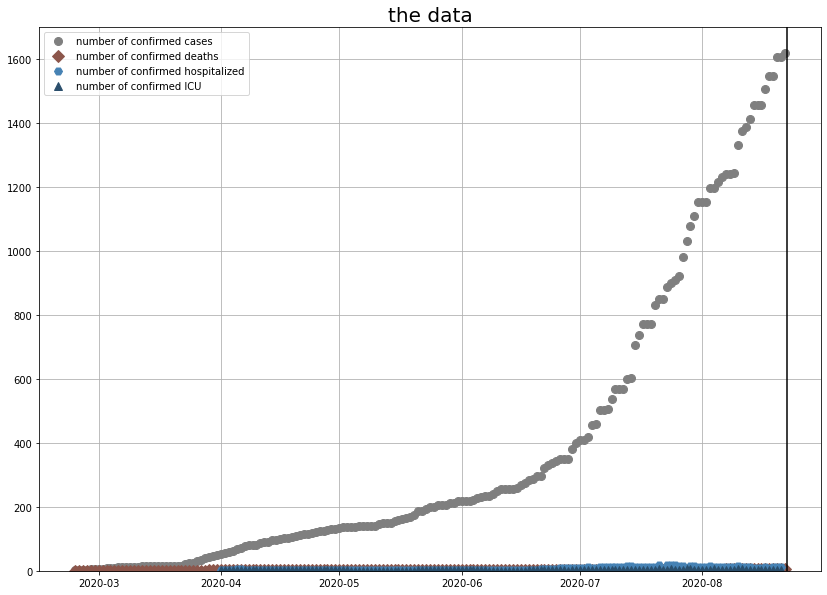

In [12]:
import matplotlib.pyplot as plt

variable_names = ['S','E','Iasym', 'Imild', 'Ipreh', 'Hmod', 'Hicu', 'Rlive', 'Rmort']
variable_index = {v:i for i,v in enumerate(variable_names)}
variable_desc = {'S':'susceptible',
                 'E':'exposed',
                 'I':'infectious',
                 'Iasym':'infectious',
                 'Iobs':'observed infectious (cumulative)',
                 'Imild':'recovering at home',
                 'Ipreh':'pre-hospital', 
                 'Hmod':'hospitalized (non-ICU)',
                 'Hicu':'ICU',
                 'Rlive':'recovered', 
                 'Rmort':'deceased',
                 'hospitalized':'hospitalized (ICU + non-ICU)',
                }
variable_colors = {'S':'tab:blue',
                   'E':'tab:orange',
                   'I':'tab:red',
                   'Iobs':'tab:gray', 
                   'Iasym':'lightcoral',
                   'Imild':'tab:olive',
                   'Ipreh':'tab:purple',
                   'Hmod':'lightsteelblue',
                   'Hicu':'#2a4e6c', # a 'darksteelblue' 
                   'Rlive':'tab:green', 
                   'Rmort':'tab:brown',
                   'hospitalized':'steelblue',
                  }

fig,ax = plt.subplots(figsize=(14,10))
ax.plot(tobs_date, obs_I, ls='none', marker='o', markersize=8, color=variable_colors['Iobs'], label='number of confirmed cases')
ax.plot(tobs_date, obs_Rmort, ls='none', marker='D', markersize=8, color=variable_colors['Rmort'], label='number of confirmed deaths')
ax.plot(thobs_date, obs_H, ls='none', marker='H', markersize=8, color=variable_colors['hospitalized'], label='number of confirmed hospitalized')
ax.plot(thobs_date, obs_Hicu, ls='none', marker='^', markersize=8, color=variable_colors['Hicu'], label='number of confirmed ICU')
ax.set_title('the data', size=20)
ax.set_ylim(bottom=0)
ax.axvline(datetime.datetime.now(), color='black')
ax.grid(True)
ax.legend()

if fractest_timedependent and create_spline_plot:
    from scipy.interpolate import BSpline
    p = data['p_fractest']
    knots_ext = np.empty(len(data['knots_fractest'])+2*p)
    if p > 0:
        knots_ext[:p] = data['knots_fractest'][0]
        knots_ext[p:-p] = data['knots_fractest']
        knots_ext[-p:] = data['knots_fractest'][-1]
    else:
        knots_ext[:] = data['knots_fractest']
    t = np.arange(1,data['nt']+1)
    t_date = np.array([refdate+datetime.timedelta(days=float(tt)) for tt in t])
    bsp = BSpline(knots_ext, data['mu_fractest'], p)
    
    fig,ax = plt.subplots(figsize=(14,8))
    tmp = ax.plot([refdate+datetime.timedelta(days=float(tt)) for tt in knots_ext[p:p+len(data['mu_fractest'])]], data['mu_fractest'], marker='o', ls='none', markersize=9)
    ax.plot(t_date, bsp(t), ls=':', color=tmp[0].get_color(), lw=2)
    ax.grid(True)
    ax.set_title('spline-interpolated "mu_fractest" (for prior distribution of fraction tested)', size=20)
    
    ax.axvline(refdate+datetime.timedelta(days=1), color='black')
    ax.axvline(datetime.datetime.now(), color='black')
None

## compile and run Stan model

In [13]:
# avoid unnecessary recompilation
if 'models' not in globals():
    models = {}
if 'fits' not in globals():
    fits = {}
if 'datachanges' not in globals():
    datachanges = {}
if 'ref' not in datachanges:
    datachanges['ref'] = None
if 'desc' not in globals():
    desc = {'ref':'reference simulation'}
for name in datachanges:
    if name not in desc:
        desc[name] = name

# allow stan_file to be dictionary containing different versions of code
# if it is not a dictionary, convert it to one
if not isinstance(stan_file, dict):
    stan_file = {'SEIR':stan_file}
    datachange_stan_key = {name:'SEIR' for name in datachanges}
else:
    if 'datachange_stan_key' not in globals():
        if len(stan_file) == 1:
            datachange_stan_key = {name:list(stan_file.keys())[0] for name in datachanges}
        else:
            logging.warning('''Use datachange_stan_key[key_datachange] = key_stan_file
to associate the data change entry with with key "key_datachange" to the stan_file entry with key "key_stan_file".''')
            raise ValueError('A dictionary "datachange_stan_key" must be used to associate data change entries with Stan file versions.')

stan_codes = {}
for stanname,filename in stan_file.items():
    with open(filename) as f:
        stan_codes[stanname] = f.read()

refit_all = False
#refit_required = {}

for name in datachanges:
    if name in models and models[name].model_code == stan_codes[datachange_stan_key[name]]:
        print('{}: unchanged model code, not recompiling'.format(datachange_stan_key[name]))
    else:
        models[name] = pystan.StanModel(file=stan_file[datachange_stan_key[name]], model_name=datachange_stan_key[name], obfuscate_model_name=False)

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

datasave = {}
for name,datachange in datachanges.items():
    datasave[name] = data.copy()
    if datachange is not None:
        datasave[name].update(datachange)
    
    if refit_all or name not in fits or get_max_rhat(fits[name]) >= 1.1:
        for itry in range(3):
            fits[name] = models[name].sampling(data=datasave[name], iter=2000, chains=4)
            max_rhat = get_max_rhat(fits[name])
            if max_rhat < 1.1:
                break
            logging.warning('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,max_rhat))
    else:
        print('found fit for "{}", not re-running model'.format(name))
    print('dataset "{}"'.format(name))
    # just print a subset of the variables (skip the long ones)
    print('\n'.join(x for x in fits[name].__str__().split('\n') if '[' not in x))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL SEIR NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


dataset "ref"
Inference for Stan model: SEIR.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma_beta            0.04  1.4e-3   0.02   0.02   0.03   0.03   0.05   0.08    153   1.02
duration_lat          3.23    0.06   1.45   1.14   2.07   3.04   4.18   6.51    554   1.01
duration_rec_asym     8.48    0.11   4.16   1.66   5.42   8.17  11.16  17.74   1383    1.0
duration_rec_mild     9.27    0.32   3.38   3.54   6.88   8.98  11.35  16.78    111   1.03
duration_pre_hosp     4.78    0.02   0.98   2.83   4.13   4.75   5.45   6.65   1619    1.0
duration_hosp_mod     6.76    0.03   0.99   4.86   6.07   6.76   7.45   8.71   1273    1.0
duration_hosp_icu    13.32    0.13   3.79   6.07  10.64  13.33  15.85  20.73    858   1.01
ini_exposed          12.74    0.19    6.2   3.68   8.18  11.76  16.39  27.43   1059    1.0
sigma_Iobs       

In [14]:
quantiles = {}
for name,fit in fits.items():
    quantiles[name] = {v:np.percentile(fit['x'][:,variable_index[v],:], q=(5,25,50,75,95), axis=0) for v in variable_names}
    quantiles[name]['hospitalized'] = np.percentile(fit['hospitalized'], q=(5,25,50,75,95), axis=0)
    quantiles[name]['Iobs'] = np.percentile(fit['obs_I_sim'], q=(5,25,50,75,95), axis=0)
    quantiles[name]['I'] = np.percentile(fit['x'][:,variable_index['Iasym'],:]+
                                         fit['x'][:,variable_index['Imild'],:]+
                                         fit['x'][:,variable_index['Ipreh'],:], q=(5,25,50,75,95), axis=0)

t_date = np.array([refdate+datetime.timedelta(days=float(tt+1)) for tt in range(data['nt'])])

## report some estimates

In [15]:
def print_report(fit, times, variables=('hospitalized'), title=None):
    print('=== {}'.format(title))
    for itime,time in enumerate(times):
        if isinstance(time,int):
            it = time
        elif isinstance(time,str):
            it = (parse(time)-refdate).days - 1
        else:
            it = (time-refdate).days - 1
        delta_day = it - (datetime.datetime.now()-refdate).days + 1
        
        if delta_day == 0:
            textday = 'today'
        elif delta_day == 1:
            textday = 'tomorrow'
        elif delta_day < 0:
            textday = '{} days ago'.format(-delta_day)
        else:
            textday = 'in {} days'.format(delta_day)
        
        print('   {} ({}):'.format(t_date[it].date(), textday))
        for v in variables:
            if v in variable_index:
                q = np.percentile(fit['x'][:,variable_index[v],it], q=(5,25,50,75,95), axis=0)
            elif v == 'Iobs':
                q = np.percentile(fit['obs_I_sim'][:,it], q=(5,25,50,75,95), axis=0)
            elif v == 'I':
                q = np.percentile(fit['x'][:,variable_index['Iasym'],it]+
                                  fit['x'][:,variable_index['Imild'],it]+
                                  fit['x'][:,variable_index['Ipreh'],it], q=(5,25,50,75,95), axis=0)
            else:
                q = np.percentile(fit[v][:,it], q=(5,25,50,75,95), axis=0)
            if v in variable_index or v == 'Iobs' or v == 'hospitalized' or v == 'I':
                print('      "{}" 50% credible interval: [{:.0f},{:.0f}]'.format(variable_desc[v],q[1],q[3]))
                print('       {}  90% credible interval: [{:.0f},{:.0f}] with a median estimate of {:.0f}'.format(' '*len(variable_desc[v]),q[0],q[-1],q[2]))
            else:
                print('      "{}" 50% credible interval: [{:.2f},{:.2f}]'.format(variable_desc[v],q[1],q[3]))
                print('       {}  90% credible interval: [{:.2f},{:.2f}] with a median estimate of {:.0f}'.format(' '*len(variable_desc[v]),q[0],q[-1],q[2]))


today = datetime.datetime.now()
times = (today, today+datetime.timedelta(days=1), today+datetime.timedelta(days=7))

for name in fits:
    print_report(fits[name], 
                 times=times, 
                 variables=('Iobs','hospitalized','Hicu'), title=desc[name])

=== reference simulation
   2020-08-22 (today):
      "observed infectious (cumulative)" 50% credible interval: [1543,1696]
                                         90% credible interval: [1413,1820] with a median estimate of 1621
      "hospitalized (ICU + non-ICU)" 50% credible interval: [12,16]
                                     90% credible interval: [10,18] with a median estimate of 14
      "ICU" 50% credible interval: [3,5]
            90% credible interval: [2,6] with a median estimate of 4
   2020-08-23 (tomorrow):
      "observed infectious (cumulative)" 50% credible interval: [1558,1723]
                                         90% credible interval: [1430,1855] with a median estimate of 1642
      "hospitalized (ICU + non-ICU)" 50% credible interval: [12,16]
                                     90% credible interval: [10,19] with a median estimate of 14
      "ICU" 50% credible interval: [3,5]
            90% credible interval: [2,6] with a median estimate of 4
   2020-08

## plot results

In [16]:
import matplotlib as mpl

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

def add_xaxis_datestyle(ax, fontsize_small=16, fontsize_large=20):
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(mpl.dates.MONDAY))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%d'))
    ax.grid(b=True, which='minor', linestyle=':')
    ax.tick_params(axis='x', which='major', pad=15, labelsize=fontsize_large)
    ax.tick_params(axis='x', which='minor', labelsize=fontsize_small)
    ax.tick_params(axis='y', which='major', labelsize=fontsize_small)
    
def add_intervention_info(ax, **kwargs):
    for iinter in range(data['ninter']):
        ax.axvline(refdate+datetime.timedelta(days=data['t_inter'][iinter]), color='tab:green')
        ax.axvline(refdate+datetime.timedelta(days=data['t_inter'][iinter]+data['len_inter'][iinter]), color='tab:red')
        ax.text(refdate+datetime.timedelta(days=data['t_inter'][iinter]+0.5*data['len_inter'][iinter]), 0.5, 'intervention {}'.format(iinter+1),
                color='tab:green', transform=ax.get_xaxis_transform(), ha='center', va='center', rotation=90, size=20)

### effective reproduction number $R_t$ plot

on 2020-08-22, Rt 90% credible interval: [0.40, 1.64] with a median estimate of 1.00


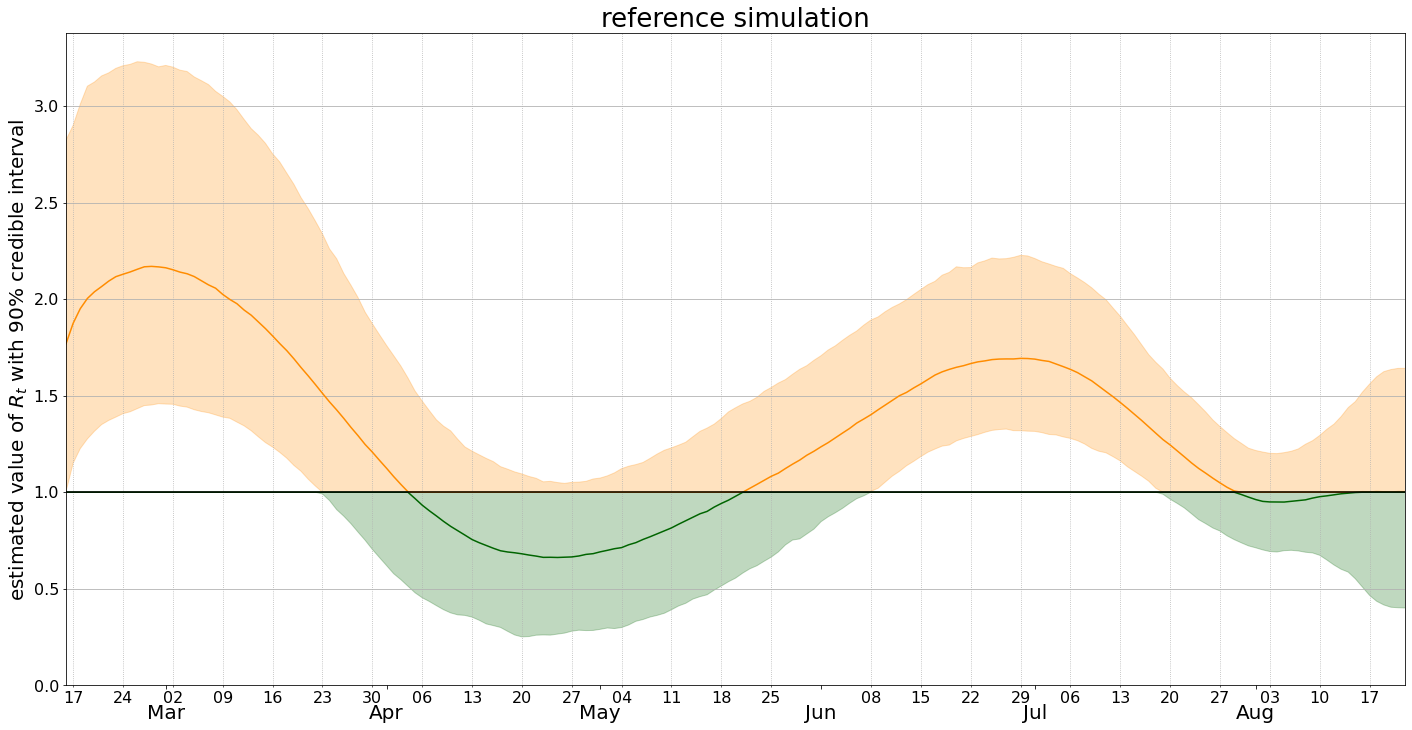

In [17]:
for name,fit in fits.items():
    if 'Rt[1]' in fit.flatnames:
        qq = np.percentile(fit['Rt'], axis=0, q=(5,25,50,75,95))
        
        fig, ax = plt.subplots()
        
        ax.fill_between(t_date, np.maximum(qq[0,:],1), np.maximum(qq[-1,:],1), color='darkorange', alpha=0.25)
        ax.fill_between(t_date, np.minimum(qq[0,:],1), np.minimum(qq[-1,:],1), color='darkgreen', alpha=0.25)
        
        ax.plot(t_date, np.maximum(qq[2,:],1), color='darkorange', label='$R_t$ estimate')
        ax.plot(t_date, np.minimum(qq[2,:],1), color='darkgreen')
        ax.axhline(1.0, color='black', zorder=5, lw=1.5)
        
        ax.grid(axis='y')
        add_xaxis_datestyle(ax)
        
        ax.set(title=desc[name], xlim=(t_date[0],datetime.datetime.now().date()))
        ax.set_ylim(bottom=0.0)
        ax.set_ylabel('estimated value of $R_t$ with 90% credible interval', size=20)
    
        print('on {}, Rt 90% credible interval: [{:.2f}, {:.2f}] with a median estimate of {:.2f}'.format(t_date[itoday].date(), qq[0,itoday], qq[-1,itoday], qq[2,itoday])) 

## quantile plots

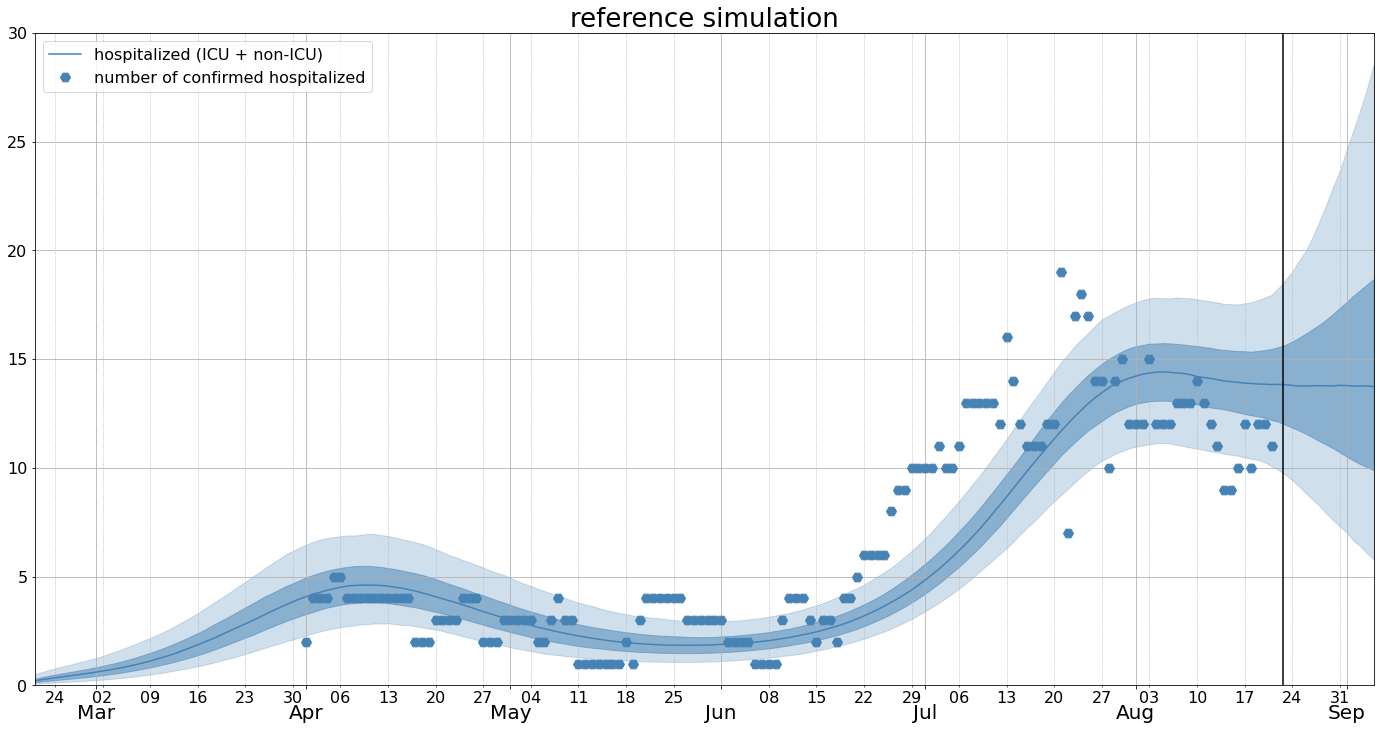

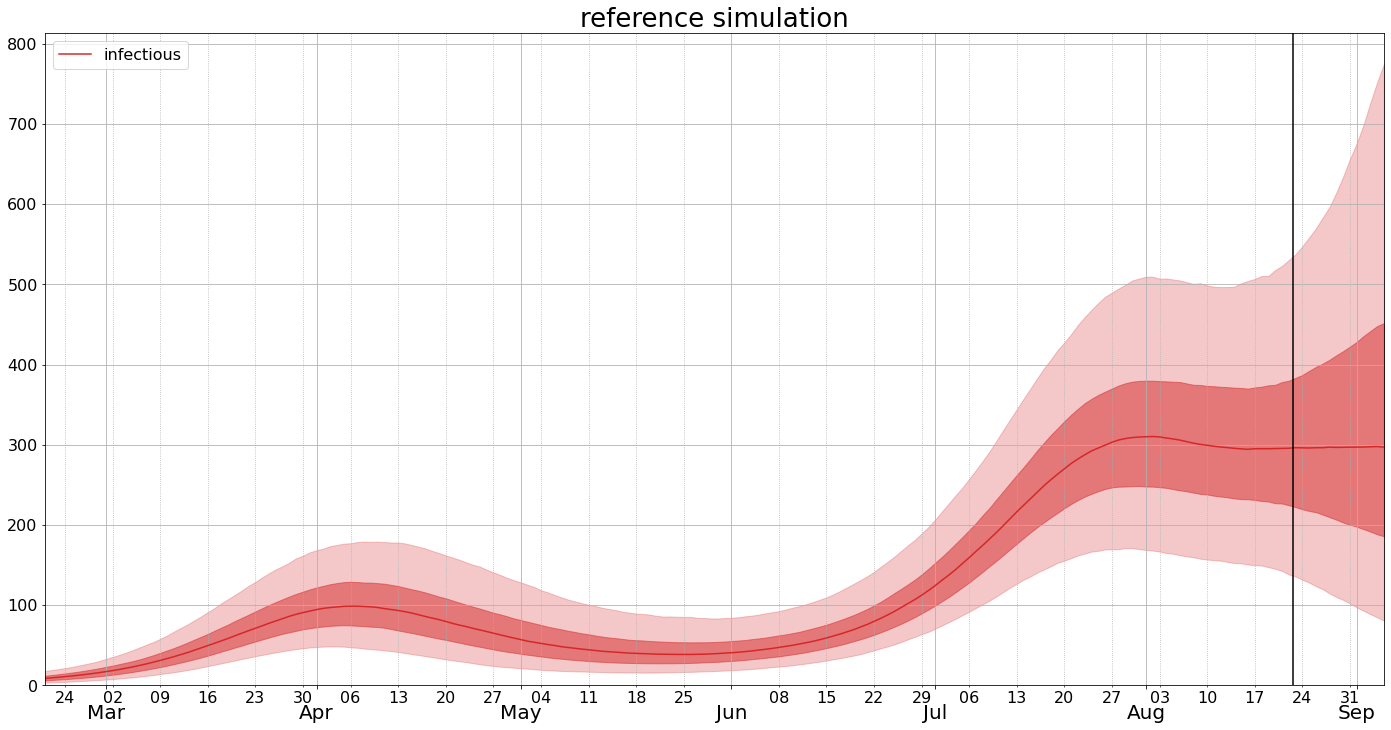

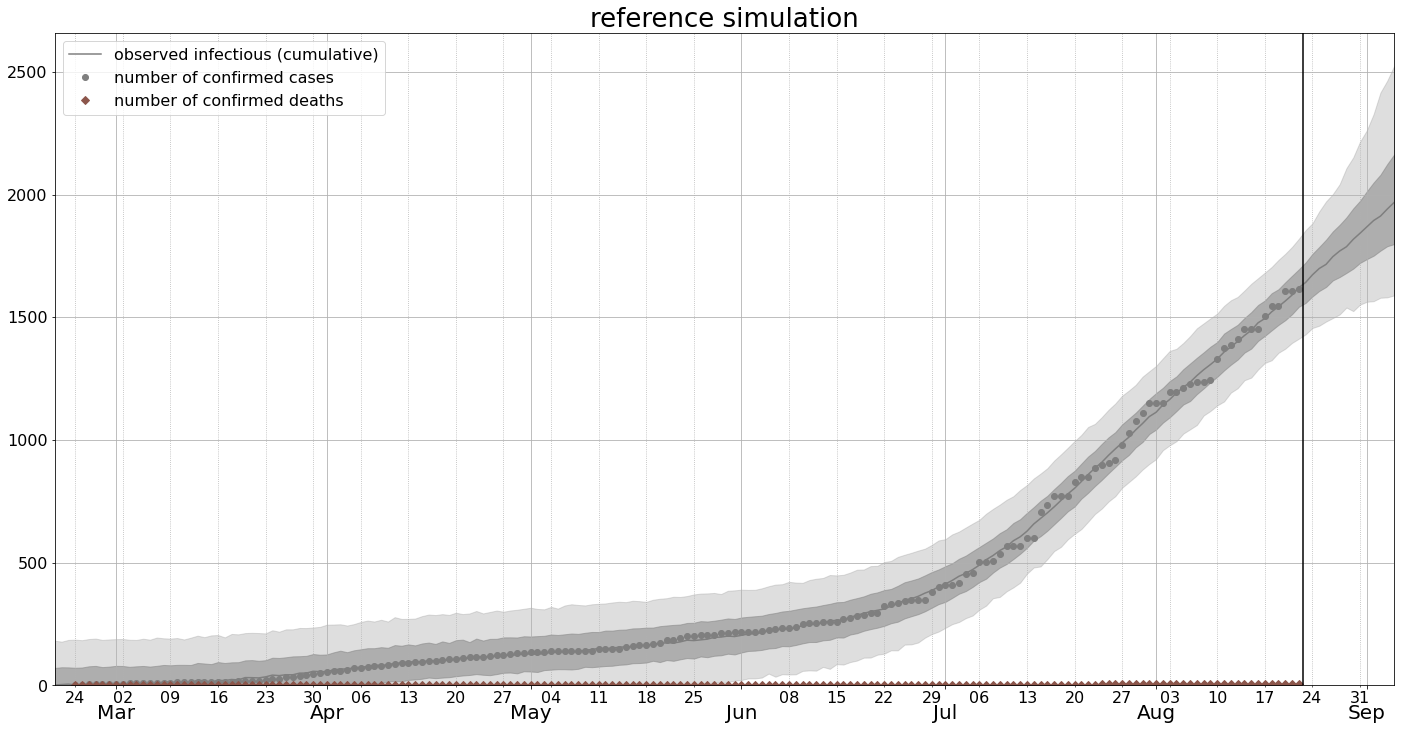

In [18]:
import matplotlib.dates as mdates

def create_quantile_plot(q, variables=('hospitalized',), title=None, daterange=None, show_data=True, show_50p=True, legendargs=None):
    fig,ax = plt.subplots()
    
    today = datetime.datetime.now()
    if daterange is None:
        index = slice(None)
    else:
        index = np.logical_and(t_date >= daterange[0], t_date <= daterange[1])
    
    for v in variables:
        ax.fill_between(t_date[index], q[v][0,index], q[v][-1,index], color=variable_colors[v], alpha=0.25)
        if show_50p:
            ax.fill_between(t_date[index], q[v][1,index], q[v][-2,index], color=variable_colors[v], alpha=0.5)
        ax.plot(t_date[index], q[v][2,index], color=variable_colors[v], label=variable_desc[v])

    if show_data:
        if 'hospitalized' in variables:
            if daterange is None:
                index = slice(None)
            else:
                index = np.logical_and(thobs_date >= daterange[0], thobs_date <= daterange[1])
            ax.plot(thobs_date[index], obs_H[index], ls='none', marker='H', markersize=10, color=variable_colors['hospitalized'], label='number of confirmed hospitalized', zorder=4)
        if 'Hicu' in variables:
            if daterange is None:
                index = slice(None)
            else:
                index = np.logical_and(thobs_date >= daterange[0], thobs_date <= daterange[1])
            ax.plot(thobs_date[index], obs_Hicu[index], ls='none', marker='^', markersize=10, color=variable_colors['Hicu'], label='number of confirmed ICU', zorder=4)
        if 'I' in variables or 'Iobs' in variables:
            if daterange is None:
                index = slice(None)
            else:
                index = np.logical_and(tobs_date >= daterange[0], tobs_date <= daterange[1])
            ax.plot(tobs_date[index], obs_I[index], ls='none', marker='o', color=variable_colors['Iobs'], label='number of confirmed cases')
            ax.plot(tobs_date[index], obs_Rmort[index], ls='none', marker='D', color=variable_colors['Rmort'], label='number of confirmed deaths')
    ax.set_ylim(bottom=0) #, top =55000)
    
    if daterange is None or (today >= daterange[0] and today <= daterange[1]):
        ax.axvline(today, color='black')

    if daterange is not None:
        ax.set_xlim(daterange)
    add_xaxis_datestyle(ax)
    if legendargs is None:
        ax.legend()
    else:
        ax.legend(**legendargs)
        
    ax.grid(True)
    if title is not None:
        ax.set_title(title)
    return ax

# customize date range variables etc. here

for name in quantiles:
    ax = create_quantile_plot(quantiles[name], variables=('hospitalized',), daterange=(t_date[5], t_date[itoday+14]), title=desc[name])
    
    ax = create_quantile_plot(quantiles[name], variables=('I',), show_data=False, daterange=(t_date[5], t_date[itoday+14]), title=desc[name])
    
    ax = create_quantile_plot(quantiles[name], variables=('Iobs',), daterange=(t_date[5], t_date[itoday+14]), title=desc[name])
    
None

## model checks & diagnostics

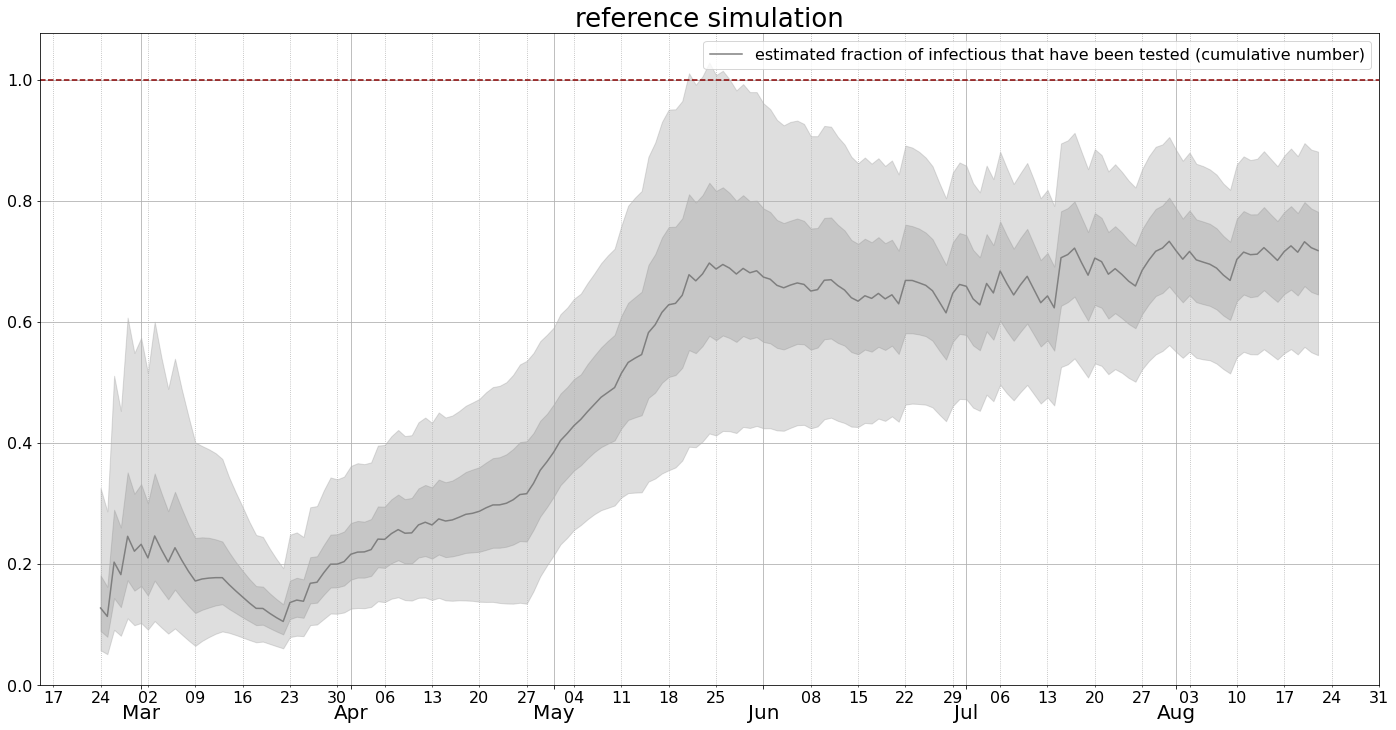

In [19]:
for name,fit in fits.items():
    qq = np.percentile(fit['fractested'], axis=0, q=(5,25,50,75,95))
    
    fig,ax = plt.subplots()
    
    ax.fill_between(tobs_date, qq[0,:], qq[-1,:], color='tab:grey', alpha=0.25)
    ax.fill_between(tobs_date, qq[1,:], qq[-2,:], color='tab:grey', alpha=0.25)
    ax.plot(tobs_date, qq[2,:], color='tab:grey', label='estimated fraction of infectious that have been tested (cumulative number)')
    
    ax.set_ylim(bottom=0.0)
    if ax.get_ylim()[1] > 1.0:
        ax.axhline(1.0, color='darkred', ls='--')
    ax.set_title(desc[name])
    add_xaxis_datestyle(ax)
    ax.grid(True)
    ax.legend()

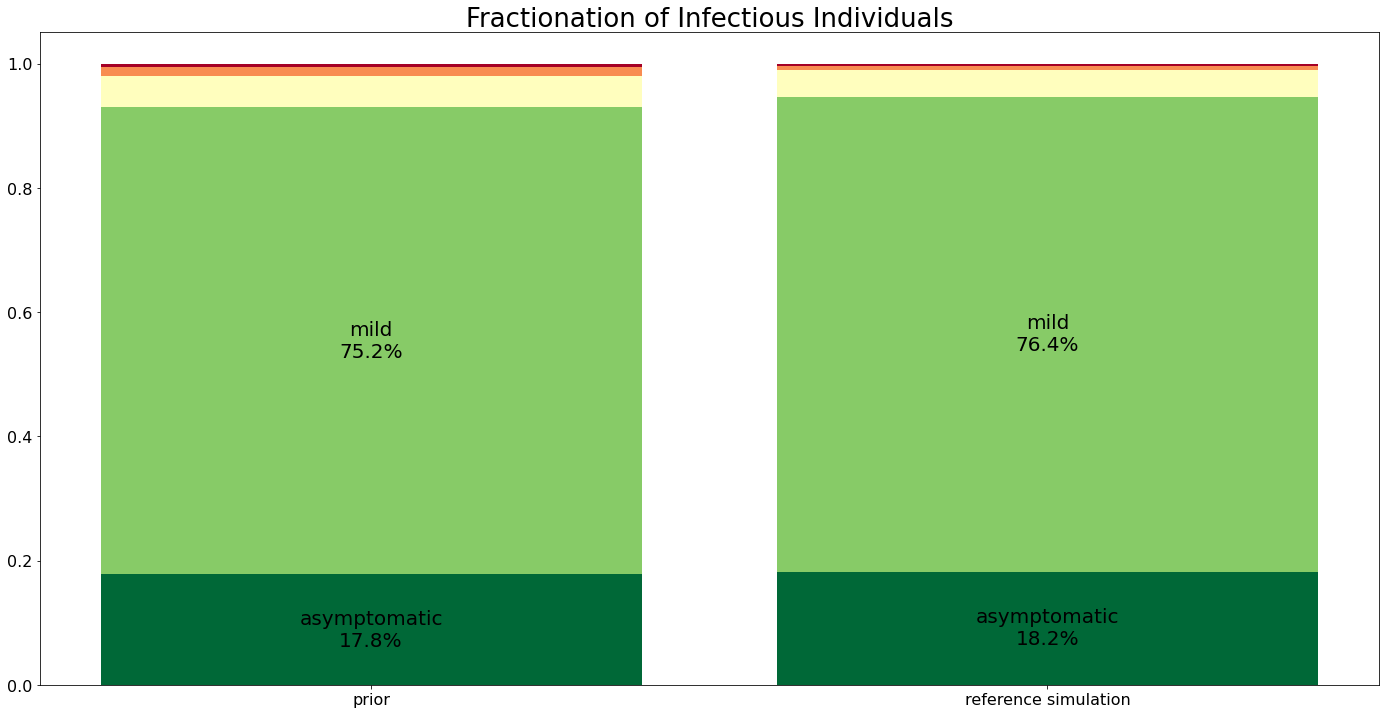

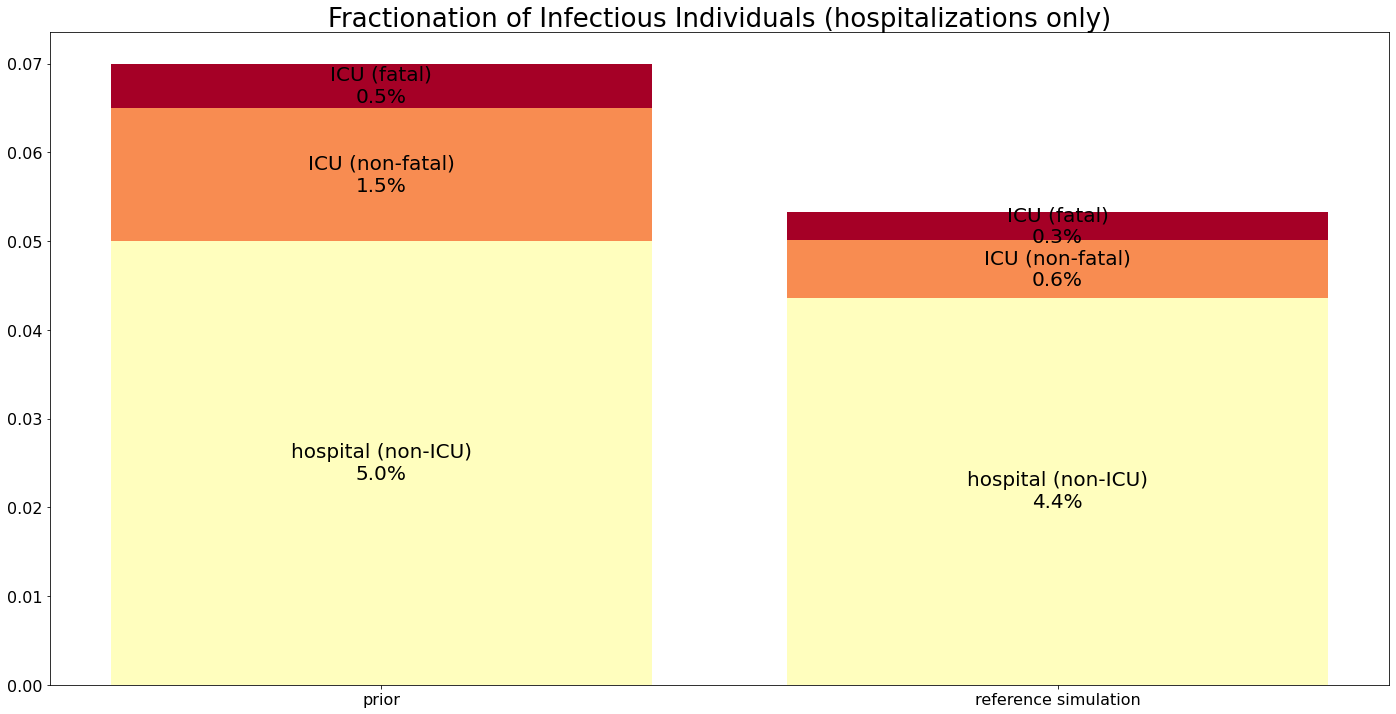

In [20]:
frac_I_agg = np.zeros((len(fits)+1,5))
# prior goes in first column
frac_I_agg[0,0] = np.mean(data['frac_asym'])
frac_I_agg[0,2] = np.mean(data['frac_hosp']) - np.mean(data['frac_icu'])
frac_I_agg[0,3] = np.mean(data['frac_icu']) - np.mean(data['frac_mort'])
frac_I_agg[0,4] = np.mean(data['frac_mort'])
frac_I_agg[0,1] = 1.0 - sum(frac_I_agg[0,:]) 

for i,name in enumerate(fits):
    frac_I_agg[i+1,:] = np.mean(fits[name]['frac_I'], axis=0)
    
cmap = plt.get_cmap('RdYlGn_r')
colors = [cmap(i/4) for i in range(5)]
desc['prior'] = 'prior'
labels = ['asymptomatic','mild','hospital (non-ICU)','ICU (non-fatal)', 'ICU (fatal)']

fig, ax = plt.subplots()
ax.set_title('Fractionation of Infectious Individuals')
bottom=np.zeros(5)
names = ['prior',*list(fits.keys())]
for i,name in enumerate(names):
    height = frac_I_agg[i,:]
    bottom[1:] = np.cumsum(height)[:-1]
    ax.bar(x=i, height=height, bottom=bottom, color=colors)
    for iy in range(len(height)):
        if height[iy] > 0.1:
            ax.text(i,bottom[iy]+0.5*height[iy], '{}\n{:.1%}'.format(labels[iy],height[iy]), size=20, va='center', ha='center')

ax.set(xticks=range(len(names)), xticklabels=[desc[name] for name in names])

fig, ax = plt.subplots()
ax.set_title('Fractionation of Infectious Individuals (hospitalizations only)')
bottom=np.zeros(3)
names = ['prior',*list(fits.keys())]
for i,name in enumerate(names):
    height = frac_I_agg[i,2:]
    bottom[1:] = np.cumsum(height)[:-1]
    ax.bar(x=i, height=height, bottom=bottom, color=colors[2:])
    for iy in range(len(height)):
        ax.text(i,bottom[iy]+0.5*height[iy], '{}\n{:.1%}'.format(labels[2+iy],height[iy]), size=20, va='center', ha='center')

ax.set(xticks=range(len(names)), xticklabels=[desc[name] for name in names])
None

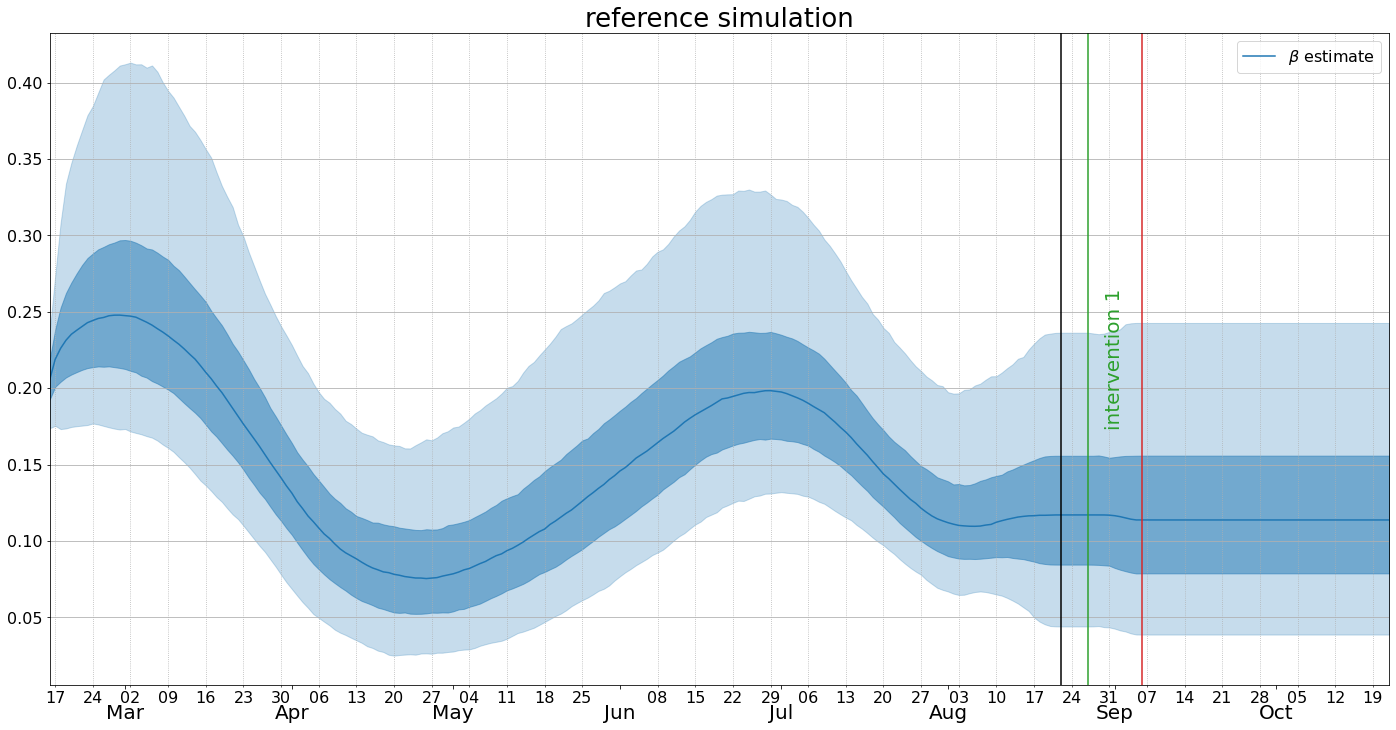

In [21]:
for name,fit in fits.items():
    if 'beta[1]' in fit.flatnames:
        qq = np.percentile(fit['beta'], axis=0, q=(5,25,50,75,95))
        
        fig, ax = plt.subplots()
        ax.fill_between(t_date, qq[0,:], qq[-1,:], color='tab:blue', alpha=0.25)
        ax.fill_between(t_date, qq[1,:], qq[-2,:], color='tab:blue', alpha=0.5)
        ax.plot(t_date, qq[2,:], color='tab:blue', label='$\\beta$ estimate')
        
        ax.grid(axis='y')
        add_xaxis_datestyle(ax)
        add_intervention_info(ax)
        ax.axvline(t_date[itoday], color='black')
        ax.legend()
        ax.set_title(desc[name])
        ax.set_xlim(left=t_date[0], right=t_date[-1])